#### Code for NWchem-Qiskit Driver
##### 1. import package

In [2]:
import os 
import sys
import yaml
import os
from qiskit_nwchem_driver import nwchem_driver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.exceptions import QiskitError
from qiskit_algorithms import VQE
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
import numpy as np
from qiskit_nwchem_driver.nwchem2yaml import extract_fields

from qiskit.circuit import QuantumCircuit


In [24]:
# data_dir = os.path.join("qe_files", "n2", "output")
# datafile = os.path.join(data_dir, "demo.out")
# data_file_yaml = os.path.join(data_dir, "demo.yaml")

data_dir = os.path.join("..","data","PW_LiH_data", "3x3_periodic", "NWChem",'1covo')
datafile = os.path.join(data_dir, "H1Li1-2.0.out")
data_file_yaml = os.path.join(data_dir, "H1Li1-2.0.yaml")

##### 2. nwchem output to yaml

In [25]:
data = extract_fields(datafile)
with open(data_file_yaml, 'w') as f:
    f.write(yaml.dump(data, default_flow_style=False)) 

##### 3. data to Qiskit electron structure problem class

In [26]:
driver = nwchem_driver.NWchem_Driver(data_file_yaml)
es_problem = driver.run()
#hamiltonian  = es_problem.hamiltonian
#print(hamiltonian.second_q_op())

h_ij up-down equal: True
eri up-down equal: True
eri up-(down-up) equal: False
eri (up-down)-(down-up) equal: True


##### 4. Mapping Hamiltonian to qubit

In [27]:
mapper = JordanWignerMapper()

In [28]:
# 5. Convertir el problema de electrónica a un circuito cuántico
#second_quantized_op = es_problem.second_q_ops()[0]
#qubit_op = mapper.map(second_quantized_op)


##### 5. specify ansatz

In [29]:
ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )




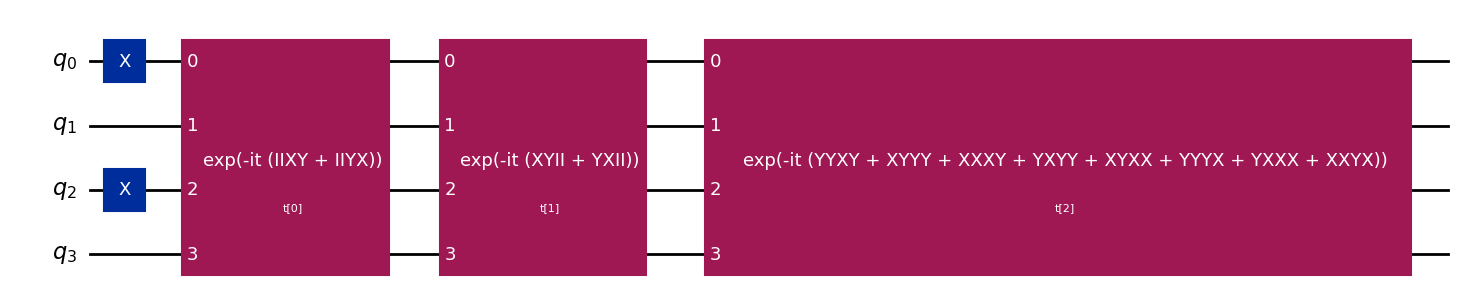

In [30]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_circuit_layout

# Dibujar el circuito generado por el ansatz UCCSD
ansatz_circuit = ansatz.decompose()  # Descompone las puertas en básicas
ansatz_circuit.draw('mpl')  # O usa 'text' o 'latex' para diferentes estilos


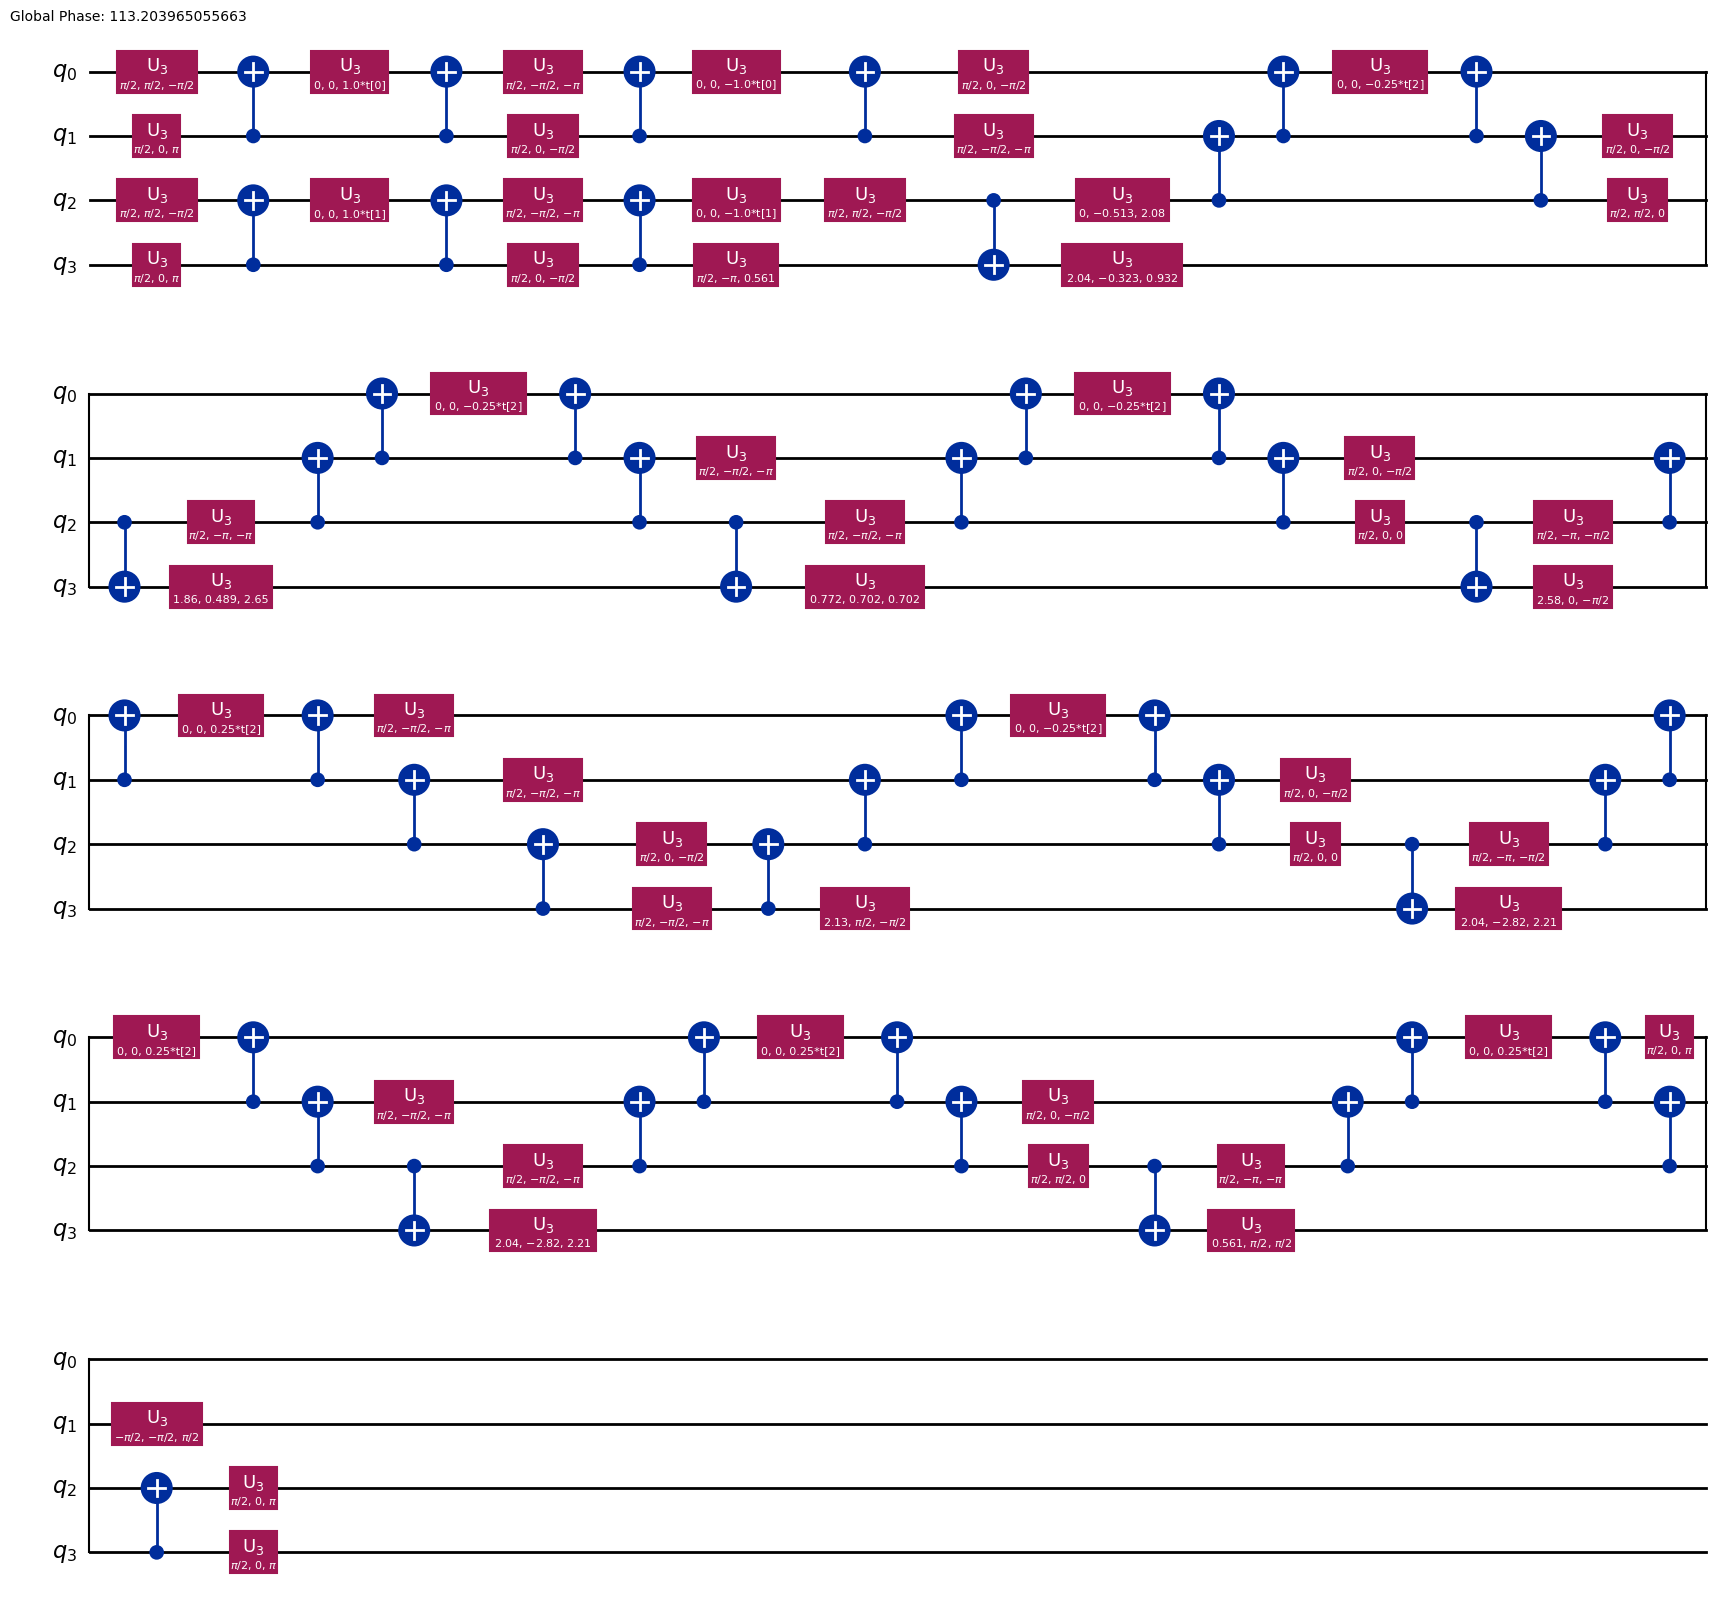

In [31]:
# Transpila el circuito a una base de puertas estándar
transpiled_circuit = transpile(ansatz_circuit, basis_gates=['u3', 'cx'])

# Dibuja el circuito transpileado
transpiled_circuit.draw('mpl')

In [32]:
from qiskit_aer import Aer, AerSimulator
from qiskit import transpile, assemble
from qiskit_aer import StatevectorSimulator


#ansatz = UCCSD(
#    es_problem.num_spatial_orbitals,
#    es_problem.num_particles,
#    mapper,
#    initial_state=HartreeFock(
 #       es_problem.num_spatial_orbitals,
#        es_problem.num_particles,
#        mapper,
#    ),
#)

# Dibuja el circuito
#ansatz_circuit = ansatz.decompose()  # Descompone en puertas estándar
#ansatz_circuit.draw('mpl')

# Asigna valores aleatorios a los parámetros
#parameters = ansatz_circuit.parameters
#param_values = {param: np.random.rand() for param in parameters}

# Vincula los parámetros
#bound_circuit = ansatz_circuit.assign_parameters(param_values)

# Transpila después de vincular parámetros
#simulator = AerSimulator(method='statevector')
#transpiled_circuit = transpile(bound_circuit, basis_gates=['u3', 'cx'])

# Ejecuta el circuito
#result = simulator.run(transpiled_circuit).result()
#statevector = result.get_statevector()

# Imprime el vector de estado resultante
#print(statevector)

##### 6. Constructing VQE and check results 

In [14]:
vqe_solver = VQE(Estimator(), ansatz, SLSQP())
#vqe_solver = VQE(StatevectorEstimator(), ansatz, SLSQP())
# vqe_solver.initial_point = [0.0] * ansatz.num_parameters
vqe_solver.initial_point = np.random.rand(ansatz.num_parameters)
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(es_problem)
print(res)
print('> Total energy from HF (Hartree):{}'.format(driver.total_energy))

/tmp/ipykernel_569/1423445988.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -0.94537949373
  - computed part:      -0.94537949373
~ Nuclear repulsion energy (Hartree): 0.0657458505
> Total ground state energy (Hartree): -0.87963364323
> Total energy from HF (Hartree):-0.7353101142
